In [1]:
import os
import ipcmagic

In [2]:
%ipcluster start -n {int(os.environ['SLURM_NNODES'])} --mpi

IPCluster is ready! (12 seconds)


In [3]:
%%px
import os
import glob
import types
import tensorflow as tf
import tensorflow_addons as tfa
from datetime import datetime
from tb_cscs import tensorboard

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
    cluster_resolver=tf.distribute.cluster_resolver.SlurmClusterResolver(),
    communication=tf.distribute.experimental.CollectiveCommunication.NCCL,
)

num_workers = int(os.environ['SLURM_NNODES'])
node_id = int(os.environ['SLURM_NODEID'])

node_id, num_workers

Out[0:1]: (0, 2)

Out[1:1]: (1, 2)

In [5]:
%%px
image_shape = (224, 224)
batch_size = 128 * num_workers

def decode(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    image = tf.image.resize_with_pad(image, *image_shape, method='bilinear')
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    return image, label

In [6]:
%%px
from albumentations import (
    Compose, HorizontalFlip, Rotate, Normalize
)

transforms = Compose([
            Rotate(limit=40, p=0.8),
            HorizontalFlip(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def aug_fn(image):
    aug_data = transforms(image=image)
    aug_img = aug_data["image"]
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

def view_image(ds):
    from matplotlib import pyplot as plt
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    print(image.shape, image.dtype)
    # denorm image
    image -= image.min()
    image /= image.max()

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

[stdout:0] (256, 224, 224, 3) float32
[stdout:1] (256, 224, 224, 3) float32


[output:0]

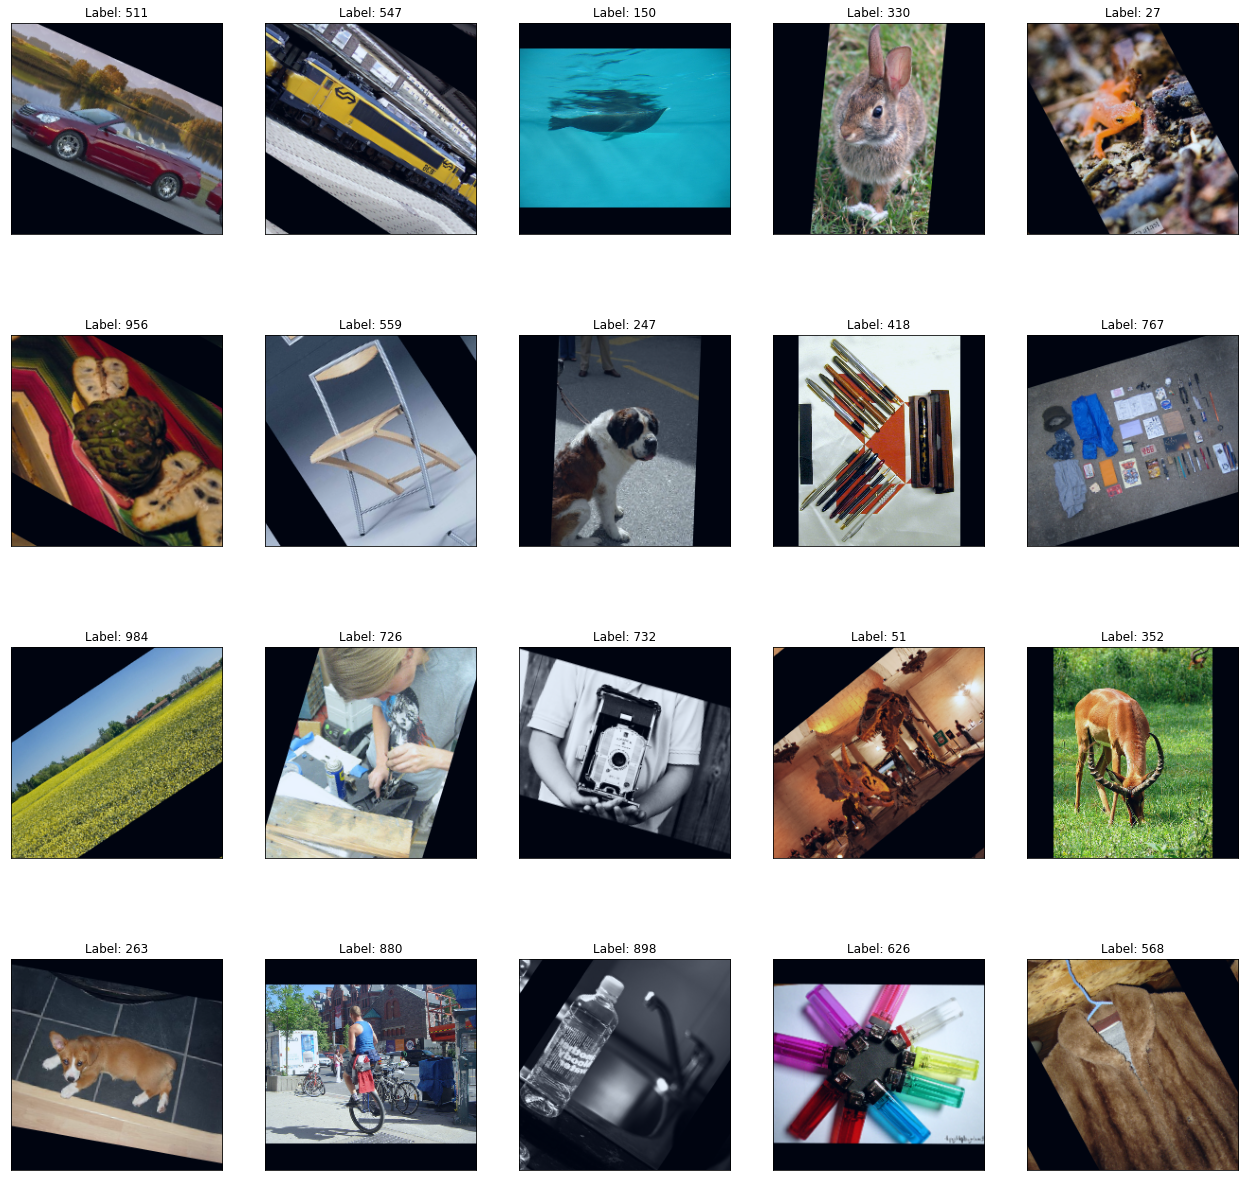

[output:1]

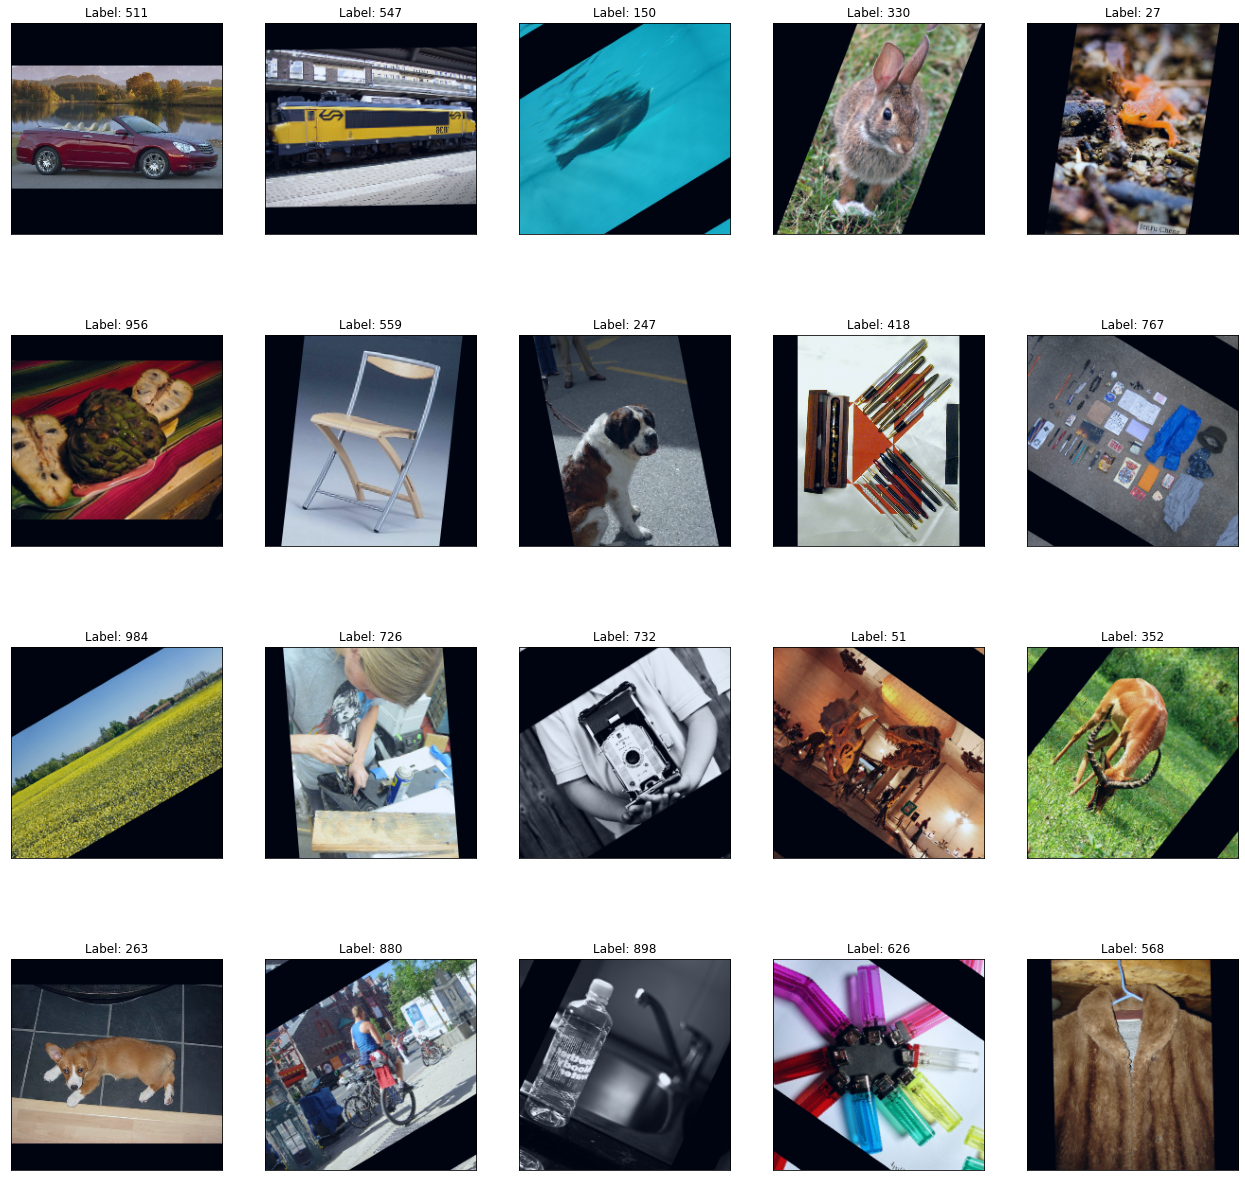

In [7]:
%%px
list_of_files = glob.glob('/scratch/snx3000/stud50/imagenet/train*')

AUTO = tf.data.experimental.AUTOTUNE
dataset = (tf.data.TFRecordDataset(list_of_files, num_parallel_reads=AUTO)
           .map(decode, num_parallel_calls=AUTO)
           .map(process_data, num_parallel_calls=12)
           .batch(batch_size)
           .prefetch(AUTO)
          )

view_image(dataset)

In [8]:
%%px
with strategy.scope():
    model = tf.keras.applications.InceptionV3(weights=None,
                                              input_shape=(*image_shape, 3),
                                              classes=1000)

    optimizer = tfa.optimizers.LAMB(lr=1e-3 * (num_workers ** 0.5))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('inceptionv3_logs',
                                                                  datetime.now().strftime("%d-%H%M")),
                                             histogram_freq=1,
                                             profile_batch='80,100')

In [9]:
%%px
fit = model.fit(dataset,
                steps_per_epoch=100,
                epochs=1,
                callbacks=[tb_callback])

100/100 [==============================] - 74s 743ms/step - loss: 6.9201 - accuracy: 0.0030


In [10]:
%reload_ext tensorboard

In [11]:
%tensorboard --logdir=inceptionv3_logs

Reusing TensorBoard on port 6007 (pid 20175), started 0:28:03 ago. (Use '!kill 20175' to kill it.)

In [50]:
%ipcluster stop